
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_auc_score, f1_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from plotnine import *
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [3]:
X = ha.drop("cp", axis = 1)
y = ha["cp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
                                        make_column_selector(dtype_include=object))],
                                        remainder = "passthrough")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
    ("classifier", KNeighborsClassifier(n_neighbors = 5))]
)

knn_fitted = knn_pipeline.fit(X_train, y_train)

knn_pred_train = knn_fitted.predict(X_train)
knn_pred_test = knn_fitted.predict(X_test)
knn_prob_test = knn_pipeline.predict_proba(X_test)

print("KNN Classification Report:\n", classification_report(y_test, knn_pred_test))
conf_matrix_knn = confusion_matrix(y_test, knn_pred_test)

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.91      0.62        22
           1       0.40      0.25      0.31         8
           2       0.43      0.15      0.22        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.32      0.33      0.29        55
weighted avg       0.40      0.45      0.37        55

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.91      0.62        22
           1       0.40      0.25      0.31         8
           2       0.43      0.15      0.22        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.32      0.33      0.29        55
weighted avg       0.40      0.45      0.37        55



/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.82      0.65        22
           1       0.36      0.50      0.42         8
           2       0.30      0.15      0.20        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.30      0.37      0.32        55
weighted avg       0.38      0.45      0.40        55

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.82      0.65        22
           1       0.36      0.50      0.42         8
           2       0.30      0.15      0.20        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.30      0.37      0.32        55
weighted avg       0.38      0.45      0.40        55



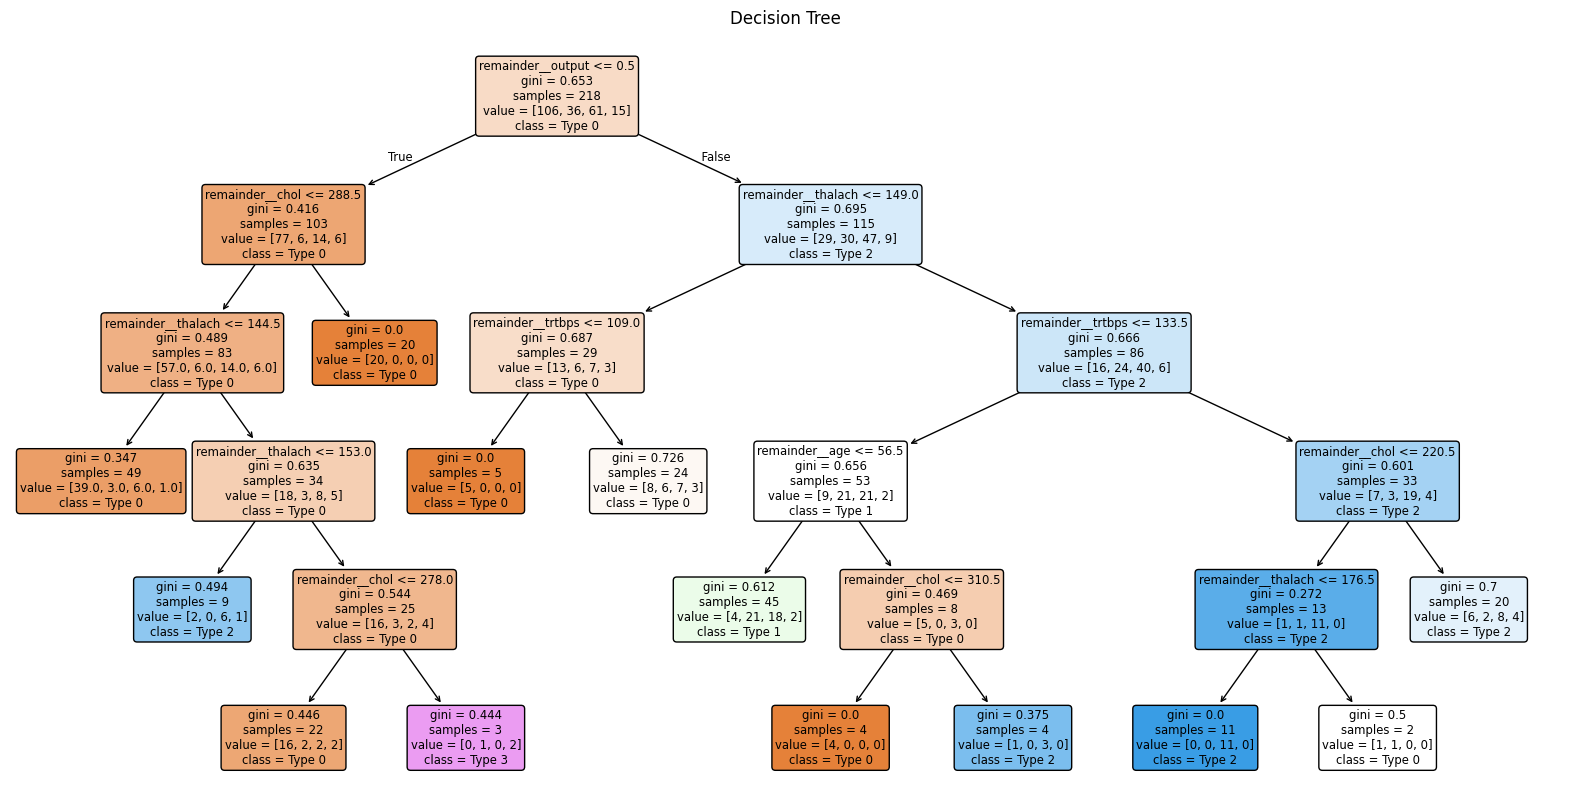

In [4]:
tree1_pipeline = Pipeline([
        ("preprocessing", ct),
        ("classifier", DecisionTreeClassifier(random_state=1, ccp_alpha=.01))
    ])

tree1_fitted = tree1_pipeline.fit(X_train, y_train)

tree_model = tree1_fitted.named_steps["classifier"]

tree1_pred_train = tree1_fitted.predict(X_train)
tree1_pred_test = tree1_fitted.predict(X_test)
tree1_prob_test = tree1_pipeline.predict_proba(X_test)

tree_rules = export_text(tree_model, feature_names=ct.get_feature_names_out())

print("Decision Tree Classification Report:\n", classification_report(y_test, tree1_pred_test))
conf_matrix_tree = confusion_matrix(y_test, tree1_pred_test)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=ct.get_feature_names_out(),
    class_names=["Type 0", "Type 1", "Type 2", "Type 3"],  # Update with your categories
    filled=True,
    rounded=True
)
plt.title("Decision Tree")
plt.show()


The first split in the decision tree is based on if the ouput is greater than 0.5. If it is less than 0.5, then the next split is if the cholesterol is less than 288.5. Continuing on that side of the tree, if the cholesterol is less than 288.5, then it will split into if thalach is less than 144.5. If the cholesterol is greater than 288.5 then it ends the split. If the output is greater than 0.5 it splits trtbps into less than 133.5. If it is less than 133.5, it goes to age, if not then it goes to chol.

In [5]:
lda_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())]
)


lda_fitted = lda_pipeline.fit(X_train, y_train)
lda_model = lda_fitted.named_steps["lda"]
lda_pred_test = lda_pipeline.predict(X_test)

print("LDA Classification Report:\n", classification_report(y_test, lda_pred_test))
conf_matrix_lda = confusion_matrix(y_test, lda_pred_test)


LDA Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.71        22
           1       0.29      0.25      0.27         8
           2       0.45      0.50      0.48        20
           3       0.00      0.00      0.00         5

    accuracy                           0.53        55
   macro avg       0.35      0.38      0.36        55
weighted avg       0.47      0.53      0.50        55

LDA Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.71        22
           1       0.29      0.25      0.27         8
           2       0.45      0.50      0.48        20
           3       0.00      0.00      0.00         5

    accuracy                           0.53        55
   macro avg       0.35      0.38      0.36        55
weighted avg       0.47      0.53      0.50        55



/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [6]:
ha["cp_is_3"] = (ha['cp'] == 3).astype(int)
ha["cp_is_2"] = (ha['cp'] == 2).astype(int)
ha["cp_is_1"] = (ha['cp'] == 1).astype(int)
ha["cp_is_0"] = (ha['cp'] == 0).astype(int)


In [7]:

def logistic_regression_cv(X, target_column, columns_to_drop):
    y = X[target_column]
    X = X.drop(columns=columns_to_drop, axis=1)
    
    ct = ColumnTransformer(
        [("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
          make_column_selector(dtype_include=object))],
        remainder="passthrough"
    )

    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=100))
    ])

    lr_scores = cross_val_score(log_pipeline, X, y, cv=5, scoring="f1_macro")

    mean_score = lr_scores.mean()
    print(f"Mean f1_macro score for {target_column}: {mean_score:.4f}")
    

cp_drop = ["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0", "cp"]
cp3_target = "cp_is_3"
cp2_target = "cp_is_2"
cp1_target = "cp_is_1"
cp0_target = "cp_is_0"

logistic_regression_cv(ha, cp3_target, cp_drop)
logistic_regression_cv(ha, cp2_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)


Mean f1_macro score for cp_is_3: 0.4810
Mean f1_macro score for cp_is_2: 0.4334
Mean f1_macro score for cp_is_1: 0.4540
Mean f1_macro score for cp_is_1: 0.4540
Mean f1_macro score for cp_is_3: 0.4810
Mean f1_macro score for cp_is_2: 0.4334
Mean f1_macro score for cp_is_1: 0.4540
Mean f1_macro score for cp_is_1: 0.4540


cp_is_3 has the highest f1 score.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [8]:
ha = ha.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis =1)

In [9]:
def compare_cp(ha, comparison_value):
    ha_filtered = ha[(ha["cp"] == 0 )| (ha["cp"] == comparison_value)]
    
    X = ha_filtered.drop("cp", axis=1)
    y = ha_filtered["cp"]

    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object))],
        remainder="passthrough")
    
    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=100))])
    
    lr_scores = cross_val_score(log_pipeline, X, y, cv=5, scoring="roc_auc")
    
    return lr_scores.mean()


roc_auc_cp0_vs_1 = compare_cp(ha, 1)
roc_auc_cp0_vs_2 = compare_cp(ha, 2)
roc_auc_cp0_vs_3 = compare_cp(ha, 3)

print(f"ROC AUC (cp=0 vs cp=1): {roc_auc_cp0_vs_1:.4f}")
print(f"ROC AUC (cp=0 vs cp=2): {roc_auc_cp0_vs_2:.4f}")
print(f"ROC AUC (cp=0 vs cp=3): {roc_auc_cp0_vs_3:.4f}")


ROC AUC (cp=0 vs cp=1): 0.8001
ROC AUC (cp=0 vs cp=2): 0.7080
ROC AUC (cp=0 vs cp=3): 0.7410
ROC AUC (cp=0 vs cp=1): 0.8001
ROC AUC (cp=0 vs cp=2): 0.7080
ROC AUC (cp=0 vs cp=3): 0.7410


The one with the best results was cp=0 vs. cp = 1